<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/NODE_(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Step-by-Step NODE (Neural Oblivious Decision Ensembles) Implementation
# Execute each step individually for better control and understanding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification")
print("=" * 80)


NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification


In [43]:

# ================================================================================
# STEP 1: Define the NODE Model Class
# ================================================================================

class NODEModel:
    """
    Neural Oblivious Decision Ensembles (NODE) implementation
    """

    def __init__(self, input_dim, num_classes, num_layers=3, tree_depth=6, num_trees=2048,
                 learning_rate=0.001, batch_size=512):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = None
        self.history = None

    def build_model(self):
        """Build the NODE model architecture"""
        inputs = layers.Input(shape=(self.input_dim,))

        # Feature preprocessing
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

        # NODE layers (simplified implementation)
        for i in range(self.num_layers):
            # Oblivious decision tree simulation
            choice_function = layers.Dense(2**self.tree_depth, activation='sigmoid')(x)
            feature_selection = layers.Dense(self.tree_depth, activation='softmax')(x)

            # Tree ensemble
            tree_outputs = []
            for j in range(min(8, self.num_trees // (2**i + 1))):  # Reduced for computational efficiency
                tree_branch = layers.Dense(64, activation='relu')(x)
                tree_branch = layers.Dropout(0.1)(tree_branch)
                tree_outputs.append(tree_branch)

            if tree_outputs:
                x = layers.Add()(tree_outputs) if len(tree_outputs) > 1 else tree_outputs[0]

            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.1)(x)

        # Final classification layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, verbose=1):
        """Train the NODE model"""
        if self.model is None:
            self.build_model()

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
        )

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=verbose
        )

        return self.history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

    def predict_classes(self, X):
        """Predict class labels"""
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)

print("✓ NODE Model class defined successfully")


✓ NODE Model class defined successfully


In [44]:

# ================================================================================
# STEP 2: Define Helper Functions
# ================================================================================

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading data...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")

    return train_df, val_df, test_df

def create_quantile_labels(df, target_col='Production (M.Ton)'):
    """Create quantile-based labels for production"""
    print("Creating quantile-based labels...")

    # Calculate quantiles
    quantiles = df[target_col].quantile([0.2, 0.4, 0.6, 0.8]).values
    print(f"Quantile thresholds: {quantiles}")

    # Create labels
    def get_label(value):
        if value <= quantiles[0]:
            return 0  # Very Low
        elif value <= quantiles[1]:
            return 1  # Low
        elif value <= quantiles[2]:
            return 2  # Medium
        elif value <= quantiles[3]:
            return 3  # High
        else:
            return 4  # Very High

    labels = df[target_col].apply(get_label)

    # Print label distribution
    label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    print("Label distribution:")
    for i, name in enumerate(label_names):
        count = (labels == i).sum()
        print(f"{name}: {count} ({count/len(labels)*100:.1f}%)")

    return labels, quantiles

def preprocess_features(train_df, val_df, test_df, target_col='Production (M.Ton)'):
    """Preprocess features and prepare data for training"""
    print("Preprocessing features...")

    # Separate features and target
    feature_cols = [col for col in train_df.columns if col != target_col]

    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()

    # Create labels
    y_train, train_quantiles = create_quantile_labels(train_df, target_col)

    # Use train quantiles for validation and test sets
    def apply_train_quantiles(df, quantiles, target_col):
        def get_label(value):
            if value <= quantiles[0]:
                return 0
            elif value <= quantiles[1]:
                return 1
            elif value <= quantiles[2]:
                return 2
            elif value <= quantiles[3]:
                return 3
            else:
                return 4
        return df[target_col].apply(get_label)

    y_val = apply_train_quantiles(val_df, train_quantiles, target_col)
    y_test = apply_train_quantiles(test_df, train_quantiles, target_col)

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())  # Use train mean for validation
    X_test = X_test.fillna(X_train.mean())  # Use train mean for test

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (X_train_scaled, y_train, X_val_scaled, y_val,
            X_test_scaled, y_test, scaler, train_quantiles)

def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate comprehensive classification metrics"""
    print(f"\n{dataset_name} Classification Metrics:")
    print("-" * 50)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report ({dataset_name}):")
    class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, dataset_name="", figsize=(6, 4)):
    """Plot confusion matrix"""
    plt.figure(figsize=figsize)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return cm

def plot_training_history(history, metric='accuracy'):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'Training {metric.title()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.title()}')
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("✓ All helper functions defined successfully")


✓ All helper functions defined successfully


In [45]:

# ================================================================================
# STEP 3: Load and Preprocess Data
# ================================================================================

print("\n" + "="*50)
print("STEP 3: LOADING AND PREPROCESSING DATA")
print("="*50)

# Load the datasets
train_df, val_df, test_df = load_and_preprocess_data()

print("✓ Data loaded successfully")



STEP 3: LOADING AND PREPROCESSING DATA
Loading data...
Train shape: (3942, 84)
Validation shape: (845, 84)
Test shape: (845, 84)
✓ Data loaded successfully


In [46]:

# ================================================================================
# STEP 4: Feature Preprocessing and Label Creation
# ================================================================================

print("\n" + "="*50)
print("STEP 4: FEATURE PREPROCESSING AND LABEL CREATION")
print("="*50)

# Preprocess features and create labels
(X_train, y_train, X_val, y_val,
 X_test, y_test, scaler, quantiles) = preprocess_features(train_df, val_df, test_df)

print("✓ Features preprocessed and labels created successfully")



STEP 4: FEATURE PREPROCESSING AND LABEL CREATION
Preprocessing features...
Creating quantile-based labels...
Quantile thresholds: [ 578.    1463.    3119.524 6540.92 ]
Label distribution:
Very Low: 793 (20.1%)
Low: 786 (19.9%)
Medium: 786 (19.9%)
High: 788 (20.0%)
Very High: 789 (20.0%)
Feature dimensions: 83
Number of classes: 5
✓ Features preprocessed and labels created successfully


In [47]:

# ================================================================================
# STEP 5: Initialize and Build NODE Model
# ================================================================================

print("\n" + "="*50)
print("STEP 5: INITIALIZING AND BUILDING NODE MODEL")
print("="*50)

# Initialize NODE model
node_model = NODEModel(
    input_dim=X_train.shape[1],
    num_classes=5,
    num_layers=3,
    tree_depth=6,
    num_trees=1024,  # Reduced for computational efficiency
    learning_rate=0.001,
    batch_size=256
)

# Build the model
model = node_model.build_model()
print(f"✓ Model built successfully with {model.count_params()} parameters")

# Display model architecture
print("\nModel Architecture Summary:")
model.summary()



STEP 5: INITIALIZING AND BUILDING NODE MODEL
✓ Model built successfully with 236549 parameters

Model Architecture Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 128)       │     10,752 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_140[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_112         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_143 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_144 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_145 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_147 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_149 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 64)        │      8,256 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_113         │ (None, 64)        │          0 │ dense_143[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_114         │ (None, 64)        │          0 │ dense_144[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_115         │ (None, 64)        │          0 │ dense_145[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_116         │ (None, 64)        │          0 │ dense_146[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_117         │ (None, 64)        │          0 │ dense_147[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_118         │ (None, 64)        │          0 │ dense_148[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_119         │ (None, 64)        │          0 │ dense_149[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_120         │ (None, 64)        │          0 │ dense_150[0][0] 

 Total params: 236,549 (924.02 KB)

 Trainable params: 235,525 (920.02 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [48]:

# ================================================================================
# STEP 6: Train the Model
# ================================================================================

print("\n" + "="*50)
print("STEP 6: TRAINING THE NODE MODEL")
print("="*50)

# Train the model
history = node_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    verbose=1
)

print("✓ Model training completed successfully")



STEP 6: TRAINING THE NODE MODEL
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.1978 - loss: 2.0359 - val_accuracy: 0.2260 - val_loss: 2.2873 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2994 - loss: 1.6527 - val_accuracy: 0.3101 - val_loss: 2.1711 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3605 - loss: 1.5004 - val_accuracy: 0.3243 - val_loss: 1.8195 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4162 - loss: 1.3491 - val_accuracy: 0.4213 - val_loss: 1.4144 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4808 - loss: 1.2257 - val_accuracy: 0.4852 - val_loss: 1.2363 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5206 - loss: 1.1221 - val_accuracy: 0.5491 - val_loss: 1.1239 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - 


STEP 7: PLOTTING TRAINING HISTORY


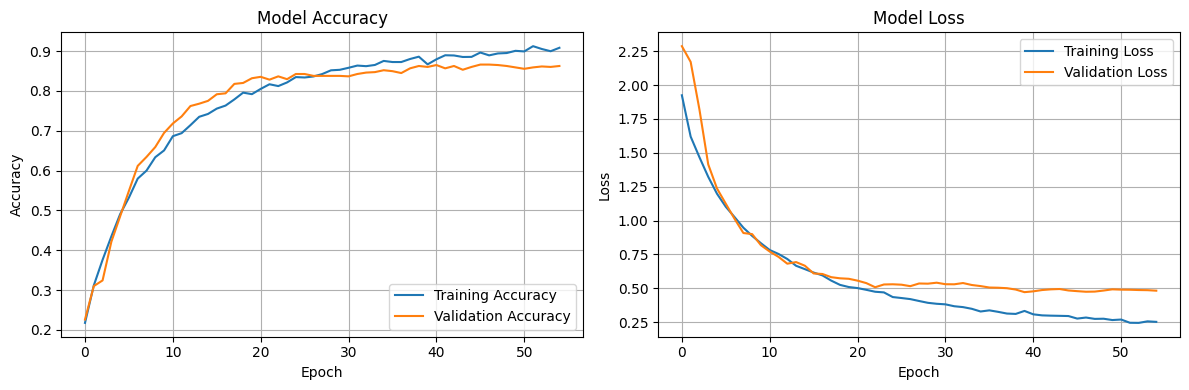

✓ Training history plotted


In [49]:

# ================================================================================
# STEP 7: Plot Training History
# ================================================================================

print("\n" + "="*50)
print("STEP 7: PLOTTING TRAINING HISTORY")
print("="*50)

# Plot training history
plot_training_history(history)
print("✓ Training history plotted")


In [50]:
# ================================================================================
# STEP 8: Make Predictions
# ================================================================================

print("\n" + "="*50)
print("STEP 8: MAKING PREDICTIONS")
print("="*50)

# Validation predictions
print("Making validation predictions...")
val_pred_proba = node_model.predict(X_val)
val_pred = np.argmax(val_pred_proba, axis=1)

# Test predictions
print("Making test predictions...")
test_pred_proba = node_model.predict(X_test)
test_pred = np.argmax(test_pred_proba, axis=1)

print("✓ Predictions completed successfully")



STEP 8: MAKING PREDICTIONS
Making validation predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Making test predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✓ Predictions completed successfully


In [51]:


# ================================================================================
# STEP 9: Calculate Performance Metrics
# ================================================================================

print("\n" + "="*50)
print("STEP 9: CALCULATING PERFORMANCE METRICS")
print("="*50)

# Calculate metrics for validation set
val_metrics = calculate_metrics(y_val, val_pred, "Validation")

# Calculate metrics for test set
test_metrics = calculate_metrics(y_test, test_pred, "Test")

print("✓ Performance metrics calculated successfully")



STEP 9: CALCULATING PERFORMANCE METRICS

Validation Classification Metrics:
--------------------------------------------------
Accuracy: 0.8604
Precision (Macro): 0.8567
Precision (Weighted): 0.8595
Recall (Macro): 0.8583
Recall (Weighted): 0.8604
F1 Score (Macro): 0.8572
F1 Score (Weighted): 0.8597

Detailed Classification Report (Validation):
              precision    recall  f1-score   support

    Very Low       0.93      0.95      0.94       185
         Low       0.82      0.84      0.83       140
      Medium       0.85      0.82      0.83       191
        High       0.81      0.78      0.79       160
   Very High       0.88      0.91      0.89       169

    accuracy                           0.86       845
   macro avg       0.86      0.86      0.86       845
weighted avg       0.86      0.86      0.86       845


Test Classification Metrics:
--------------------------------------------------
Accuracy: 0.8462
Precision (Macro): 0.8462
Precision (Weighted): 0.8474
Recall (Ma


STEP 10: GENERATING CONFUSION MATRICES
Generating validation confusion matrix...


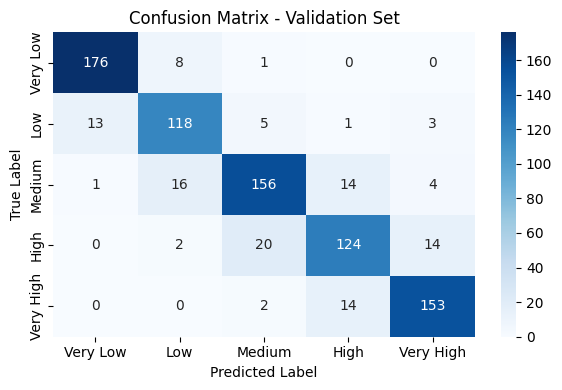

Generating test confusion matrix...


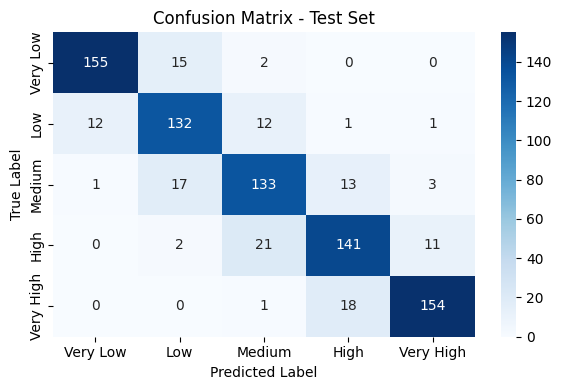

✓ Confusion matrices generated successfully


In [52]:

# ================================================================================
# STEP 10: Generate Confusion Matrices
# ================================================================================

print("\n" + "="*50)
print("STEP 10: GENERATING CONFUSION MATRICES")
print("="*50)

# Plot confusion matrices
print("Generating validation confusion matrix...")
val_cm = plot_confusion_matrix(y_val, val_pred, "Validation Set")

print("Generating test confusion matrix...")
test_cm = plot_confusion_matrix(y_test, test_pred, "Test Set")

print("✓ Confusion matrices generated successfully")


In [53]:

# ================================================================================
# STEP 11: Final Results Summary
# ================================================================================

print("\n" + "="*80)
print("STEP 11: FINAL RESULTS SUMMARY")
print("="*80)

print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Validation Macro F1: {val_metrics['f1_macro']:.4f}")
print(f"Validation Weighted F1: {val_metrics['f1_weighted']:.4f}")
print()
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Macro F1: {test_metrics['f1_macro']:.4f}")
print(f"Test Weighted F1: {test_metrics['f1_weighted']:.4f}")

# Display quantile information
print(f"\nQuantile Thresholds Used:")
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
print(f"Very Low: ≤ {quantiles[0]:.3f}")
print(f"Low: {quantiles[0]:.3f} - {quantiles[1]:.3f}")
print(f"Medium: {quantiles[1]:.3f} - {quantiles[2]:.3f}")
print(f"High: {quantiles[2]:.3f} - {quantiles[3]:.3f}")
print(f"Very High: > {quantiles[3]:.3f}")

print("\n✓ MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)



STEP 11: FINAL RESULTS SUMMARY
Validation Accuracy: 0.8604
Validation Macro F1: 0.8572
Validation Weighted F1: 0.8597

Test Accuracy: 0.8462
Test Macro F1: 0.8458
Test Weighted F1: 0.8466

Quantile Thresholds Used:
Very Low: ≤ 578.000
Low: 578.000 - 1463.000
Medium: 1463.000 - 3119.524
High: 3119.524 - 6540.920
Very High: > 6540.920

✓ MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!


In [54]:

# ================================================================================
# STEP 12: Additional Analysis (Optional)
# ================================================================================

print("\n" + "="*50)
print("STEP 12: ADDITIONAL ANALYSIS")
print("="*50)

# Feature importance analysis (if needed)
print("Model is ready for additional analysis or predictions on new data.")

# You can now use the trained model for predictions:
# new_predictions = node_model.predict(new_data_scaled)
# new_classes = node_model.predict_classes(new_data_scaled)


STEP 12: ADDITIONAL ANALYSIS
Model is ready for additional analysis or predictions on new data.
